In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans

In [3]:
# import the data
df = pd.read_csv('Credit_card_dataset.csv')
df.head()

,CUST_ID,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
0,C10001,0.818182,95.40,201.802084,1000.0,0.000000
1,C10002,0.909091,0.00,4103.032597,7000.0,6442.945483
2,C10003,1.000000,773.17,622.066742,7500.0,0.000000
3,C10004,0.636364,1499.00,0.000000,7500.0,205.788017
4,C10005,1.000000,16.00,678.334763,1200.0,0.000000


In [4]:
# general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CUST_ID            8950 non-null   object 
 1   BALANCE_FREQUENCY  8950 non-null   float64
 2   PURCHASES          8950 non-null   float64
 3   PAYMENTS           8950 non-null   float64
 4   CREDIT_LIMIT       8949 non-null   float64
 5   CASH_ADVANCE       8950 non-null   float64
dtypes: float64(5), object(1)
memory usage: 419.7+ KB


In [5]:
# summary stats
df.describe()

,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
count,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000
mean,0.877271,1003.204834,1733.143852,4494.449450,978.871112
std,0.236904,2136.634782,2895.063757,3638.815725,2097.163877
min,0.000000,0.000000,0.000000,50.000000,0.000000
25%,0.888889,39.635000,383.276166,1600.000000,0.000000
50%,1.000000,361.280000,856.901546,3000.000000,0.000000
75%,1.000000,1110.130000,1901.134317,6500.000000,1113.821139
max,1.000000,49039.570000,50721.483360,30000.000000,47137.211760


In [6]:
# check for missing values
df.isnull().sum()

CUST_ID              0
BALANCE_FREQUENCY    0
PURCHASES            0
PAYMENTS             0
CREDIT_LIMIT         1
CASH_ADVANCE         0
dtype: int64

In [7]:
# drop null values
df.dropna(inplace=True)

In [8]:
# drop customer id, it is just an identifier so no need to encode it
df.drop('CUST_ID', axis=1, inplace= True)

In [9]:
df.head()

,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
0,0.818182,95.40,201.802084,1000.0,0.000000
1,0.909091,0.00,4103.032597,7000.0,6442.945483
2,1.000000,773.17,622.066742,7500.0,0.000000
3,0.636364,1499.00,0.000000,7500.0,205.788017
4,1.000000,16.00,678.334763,1200.0,0.000000


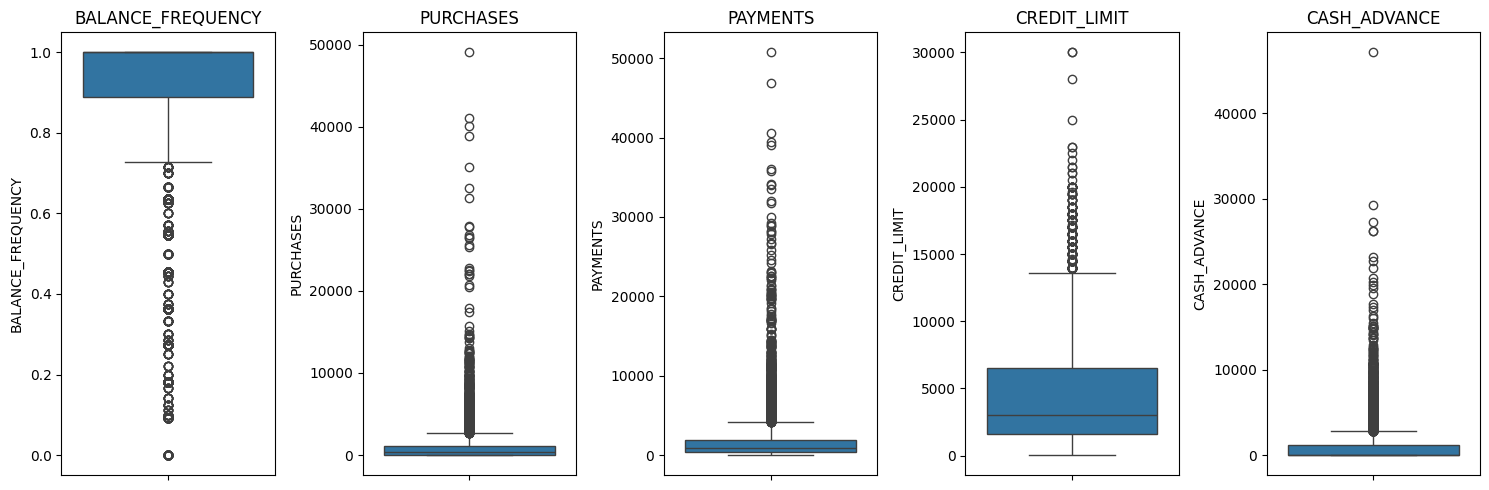

In [10]:
# check for outliers
# Plot separate box plots for each numerical feature
features = df.columns
plt.figure(figsize=(15, 5))

for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    sns.boxplot(y=df[feature])
    plt.title(feature)
    plt.tight_layout()

plt.show()


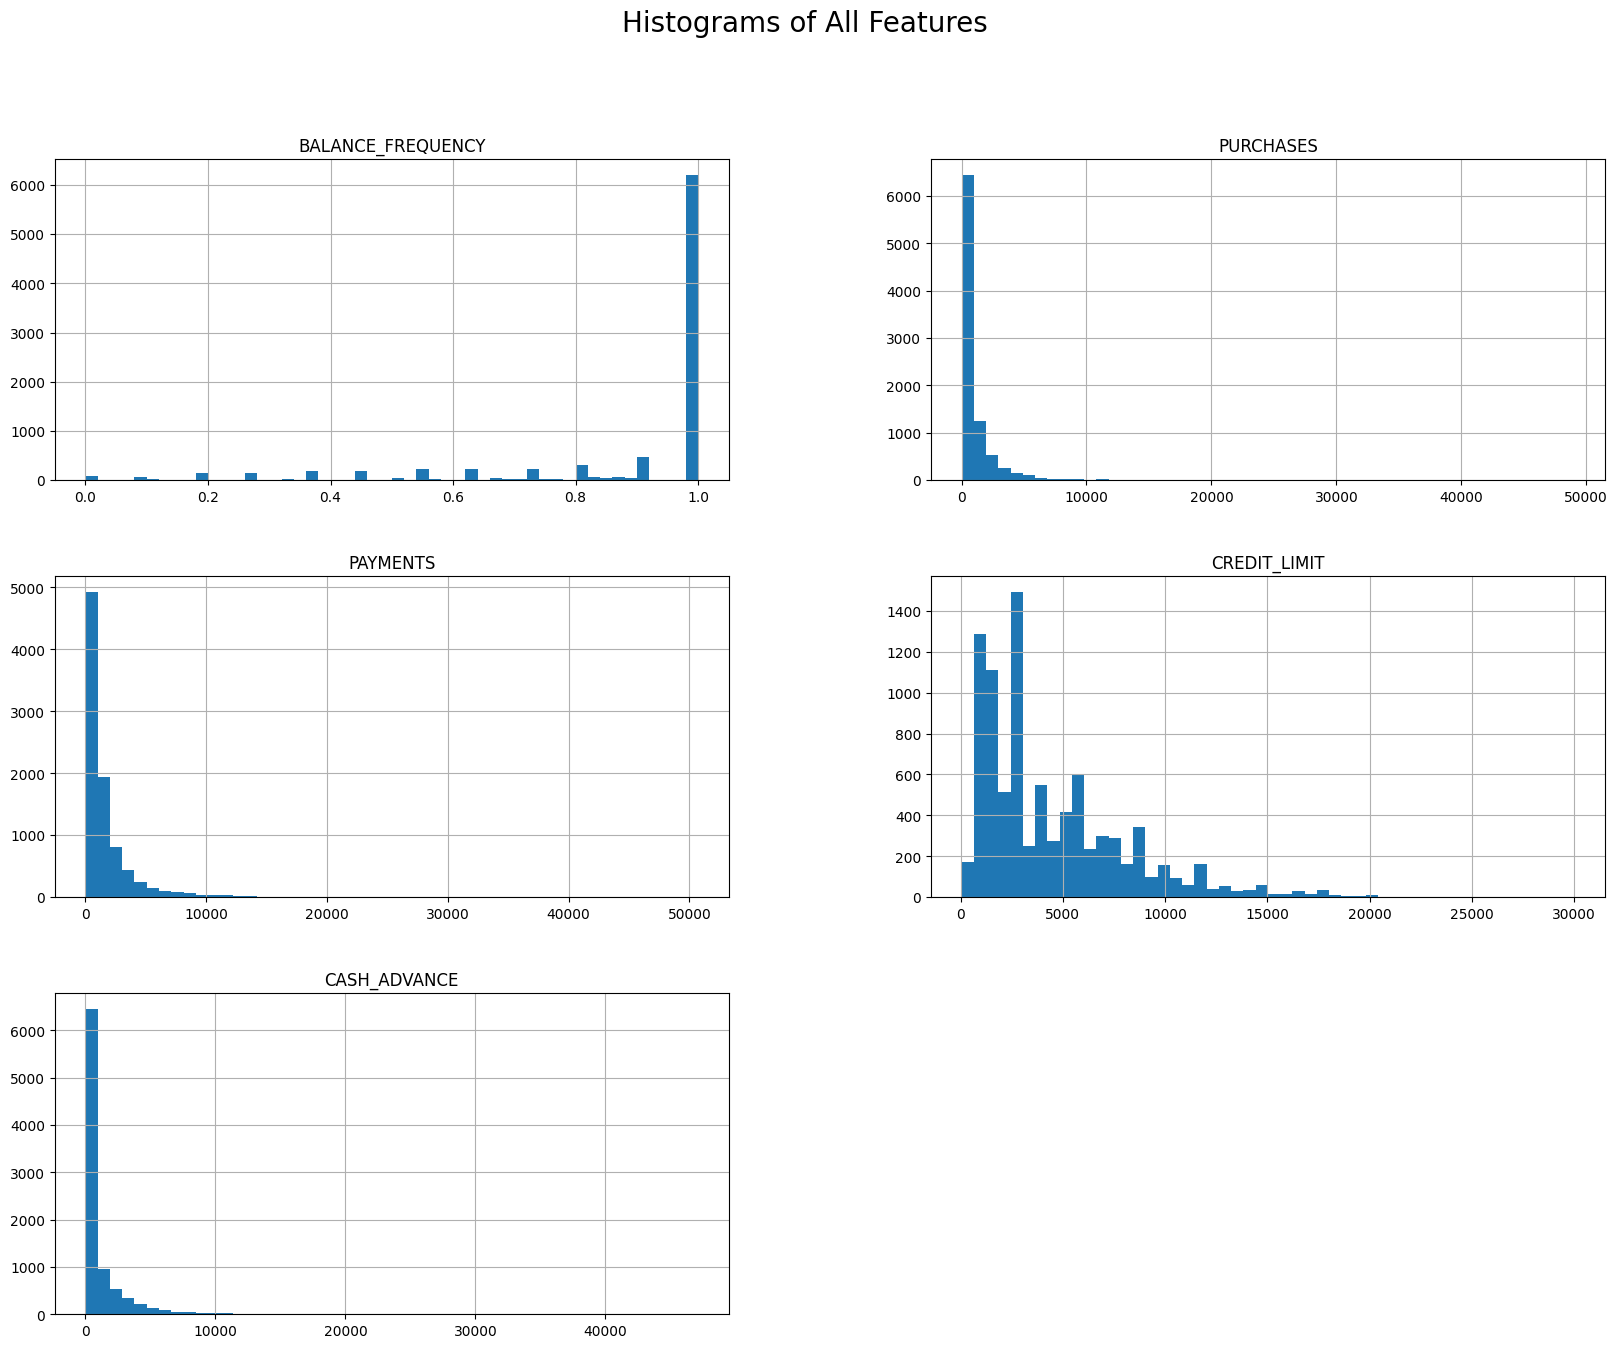

In [11]:
# Plot histograms for all numerical features
df.hist(bins=50, figsize=(20, 15))
plt.suptitle("Histograms of All Features", fontsize=20)
plt.show()

In [12]:
# handle outliers by winsorization on all numerical columns
# Create a copy of the dataframe to preserve the original data
df_capped = df.copy()

# Get list of all numerical columns
numeric_cols = df_capped.select_dtypes(include=['float64', 'int64']).columns

# Iterate over each numerical column and cap the outliers
for col in numeric_cols:
    Q1 = df_capped[col].quantile(0.25)
    Q3 = df_capped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values outside the bounds
    df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
    print(f"{col}:")
    print(f"  Lower bound = {lower_bound:.2f}, Upper bound = {upper_bound:.2f}")

# Display summary statistics after winsorization
df_capped.describe()



BALANCE_FREQUENCY:
  Lower bound = 0.72, Upper bound = 1.17
PURCHASES:
  Lower bound = -1565.76, Upper bound = 2715.73
PAYMENTS:
  Lower bound = -1893.71, Upper bound = 4178.27
CREDIT_LIMIT:
  Lower bound = -5750.00, Upper bound = 13850.00
CASH_ADVANCE:
  Lower bound = -1670.80, Upper bound = 2784.67


,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
count,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000
mean,0.931610,737.218384,1347.265509,4419.295802,672.536861
std,0.110968,879.519446,1272.869575,3383.944461,998.586486
min,0.722223,0.000000,0.000000,50.000000,0.000000
25%,0.888889,39.800000,383.282850,1600.000000,0.000000
50%,1.000000,361.490000,857.062706,3000.000000,0.000000
75%,1.000000,1110.170000,1901.279320,6500.000000,1113.868654
max,1.000000,2715.725000,4178.274025,13850.000000,2784.671635


In [13]:
# hierarchical clustering to identify the inherent groupings within the data
# select the two features for clustering
features = ['PURCHASES', 'CREDIT_LIMIT']
data = df_capped[features]

In [15]:
# standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

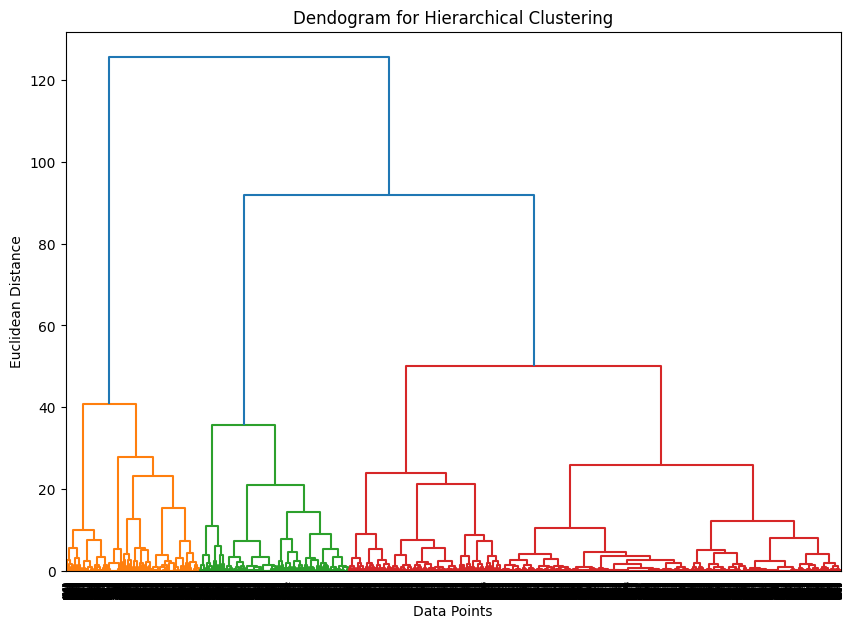

In [16]:
# plot the dendogram to visualize hierarchical clustering structure
plt.figure(figsize=(10, 7))
plt.title('Dendogram for Hierarchical Clustering')
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

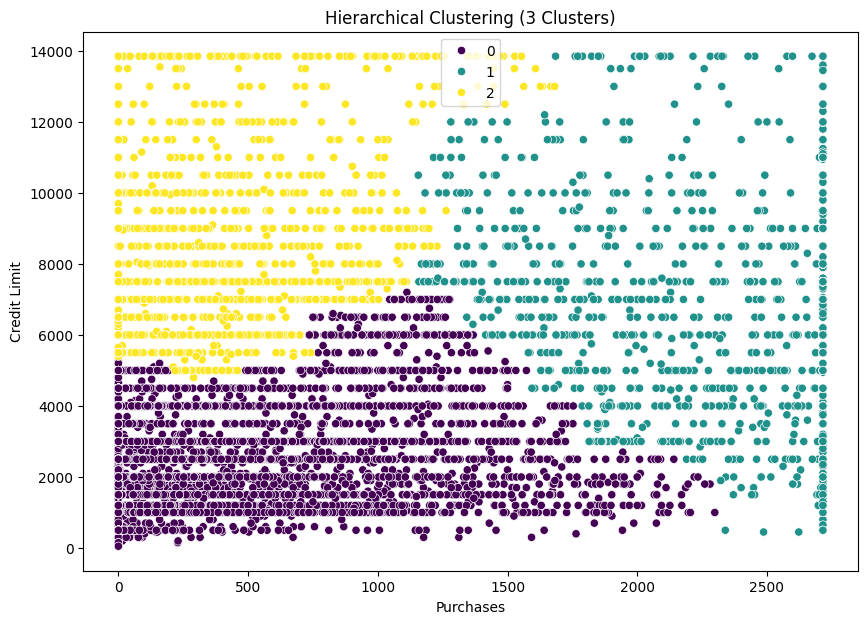

In [18]:
# Based on the dendrogram, use 3 as number of clusters
agg_cluster = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg_cluster.fit_predict(data_scaled)

# Plot the clusters from hierarchical clustering
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data['PURCHASES'], y=data['CREDIT_LIMIT'], hue=labels_agg, palette='viridis')
plt.title("Hierarchical Clustering (3 Clusters)")
plt.xlabel("Purchases")
plt.ylabel("Credit Limit")
plt.show()

`Cluster 2 (Purple)`

- Lower to mid-range credit limits (up to ~8,000).

- Wide range of purchases (0 to ~2,500).

- Represents the largest segment in this plot. These might be standard or entry-level customers who vary widely in spending.

`Cluster 1 (Yellow)`

- Higher credit limits (above ~8,000).

- Relatively low purchases (mostly below 1,000).

- Indicates customers with a high limit who do not utilize much of their purchasing power—possibly an underutilized segment.

`Cluster 0 (Teal)`

- Higher credit limits (above ~8,000).

- Moderate to high purchases (ranging ~1,000 to 2,500+).

- Likely your more active or premium users, taking advantage of their higher credit limits with consistent spending.

In [19]:
# Perform K-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(data_scaled)

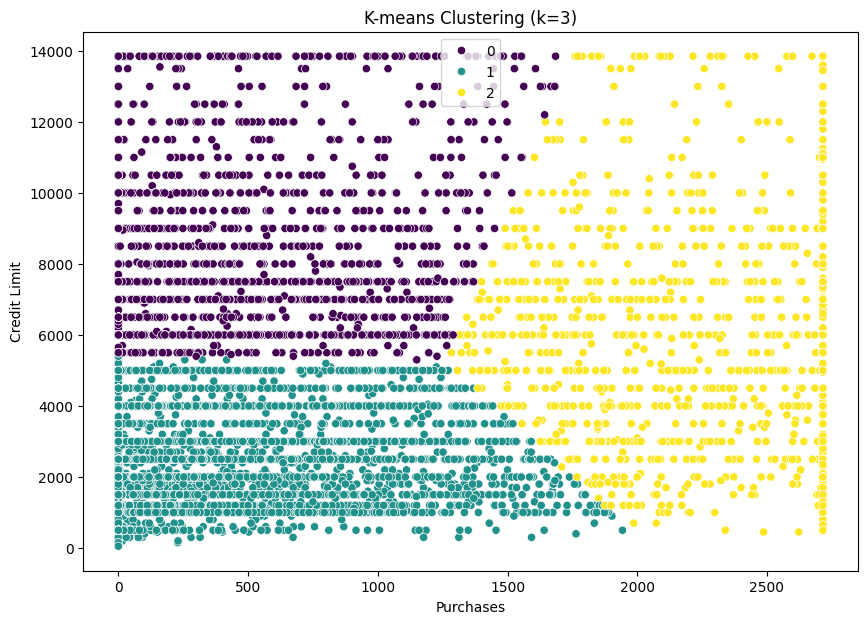

In [20]:
# Plot the clusters from K-means
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data['PURCHASES'], y=data['CREDIT_LIMIT'], hue=labels_kmeans, palette='viridis')
plt.title("K-means Clustering (k=3)")
plt.xlabel("Purchases")
plt.ylabel("Credit Limit")
plt.show()

`Cluster 1 (Teal)`:

- Lower credit limits (mostly below ~7,500).

- Lower to moderate purchases (0–1,200 range).

- Represents customers with modest purchasing behavior and smaller credit lines.

`Cluster 0 (Purple)`:

- Higher credit limits (above ~7,500).

- Lower to moderate purchases (0–1,200 range).

- These are customers with ample credit lines who aren’t making large purchases.

`Cluster 2 (Yellow)`:

- Broad range of credit limits (0–14,000).

- Higher purchases (roughly 1,200–2,600).

- A more active/spend-heavy segment, spanning both low and high credit limits.

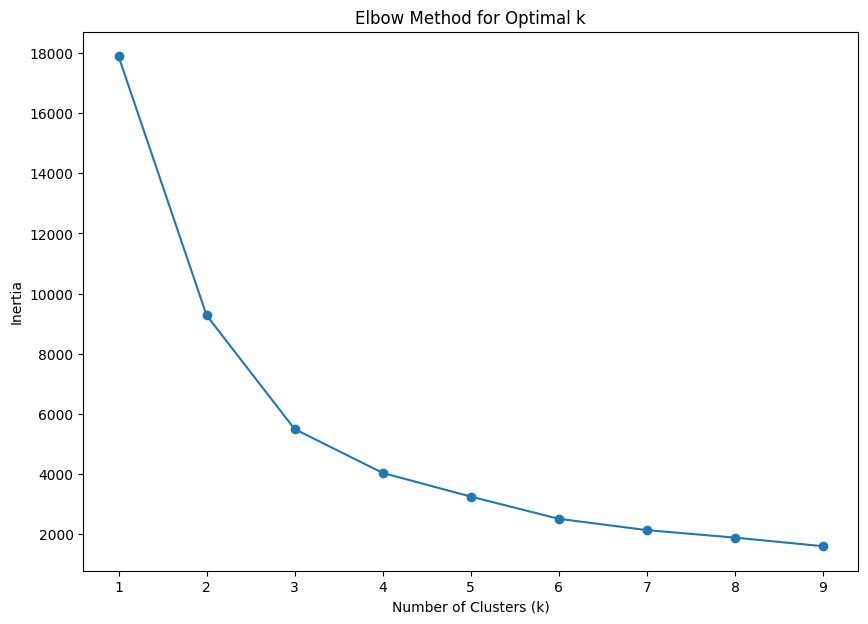

In [21]:
# Find the best k value using the Elbow Method
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(data_scaled)
    inertia.append(kmeans_model.inertia_)

plt.figure(figsize=(10, 7))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.show()

Elbow method suggests that `k=3` is optimal

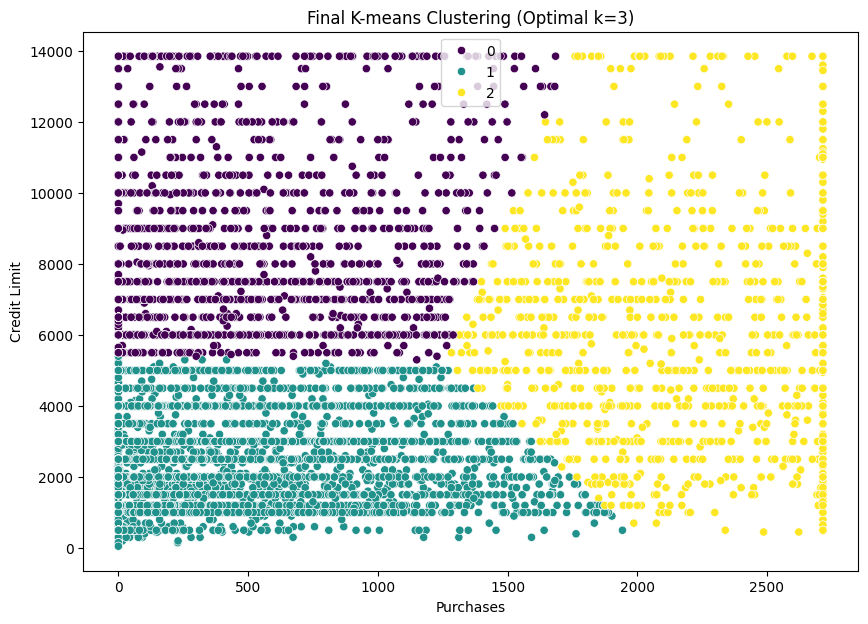

In [22]:
# Re-run K-means with the optimal k(k=3) from the elbow plot
kmeans_final = KMeans(n_clusters=3, random_state=42)
labels_final = kmeans_final.fit_predict(data_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=data['PURCHASES'], y=data['CREDIT_LIMIT'], hue=labels_final, palette='viridis')
plt.title("Final K-means Clustering (Optimal k=3)")
plt.xlabel("Purchases")
plt.ylabel("Credit Limit")
plt.show()